# Estimate p-Thyrosim parameters

In [1]:
using Distributed
addprocs(8)

@everywhere begin
    using DifferentialEquations
    using Thyrosim
    using DiffEqCallbacks
    using DiffEqParamEstim
    using SharedArrays
end

using Plots
using Optim

┌ Info: Precompiling DiffEqParamEstim [1130ab10-4a5a-5621-a13d-e4788d82bd4c]
└ @ Base loading.jl:1273
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273


# Define error functions for the 3 datasets

## Blakesley

Used to fit TSH and T4 values. 

## Jonklaas

Used to fit T3 values.

## Schneider

Used as model verification. We simulate patients according to the number of days the patient achieved euthyrodism using the given dose, then calculate if their TSH levels are within [0.45, 4.5] mIU/ml.

## Parameter definition:
- `p[55]:` Daily T4 oral dose
- `p[56]:` Daily T3 oral dose

## Error definition:

For Blakesley and Jonklaas data, we calculate the residual loss between thyrosim and data. For Schneider data, the loss is defined as:

+ When given an euthyroid T4 dose, if any TSH values $\notin [0.5, 4.5]$ in the last 24h of simulation, then error + 1 (i.e. **patients receiving correct dose should have normal TSH**)
+ When given the initial T4 dose, if the initial T4 dose is not equal to euthyroid T4 dose, and all TSH values $\in [0.5, 4.5]$, then error + 1 (i.e. **patients not receiving correct dose should NOT have normal TSH**)

## Objective function 
+ `current_iter` stores only the parameters that are being optimized. 
+ `p` stores the full parameter vector. It is initialized separately for each patient and contains the parameters in `current_iter`. We update these parameters using `fitting_index`. 

## Import data and initial conditions

In [2]:
#schneider data
train, test, toy = schneider_data();

#blakesley data & tspan
my_time, my400_data, my450_data, my600_data = blakesley_data()
blakesley_tspan = (my_time[1], my_time[end])

#jonklaas data & tspan
patient_param, patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
jonklaas_tspan = (0.0, 8.0)

(0.0, 8.0)

In [80]:
function objective(
    p_being_optimized::Vector, 
    fitting_index::SharedArray, 
    blakesley_time::Vector,
    blakesley_my400_data::Matrix, 
    blakesley_my450_data::Matrix, 
    blakesley_my600_data::Matrix,
    jonklaas_time::Vector, 
    jonklaas_patient_t4::Matrix, 
    jonklaas_patient_t3::Matrix, 
    jonklaas_patient_tsh::Matrix, 
    jonklaas_patient_param::Matrix, 
    jonklaas_patient_dose::Matrix,
    schneider_height::SharedArray, 
    schneider_weight::SharedArray, 
    schneider_sex::SharedArray, 
    schneider_tspan::SharedArray, 
    schneider_init_tsh::SharedArray, 
    schneider_euthy_dose::SharedArray, 
    schneider_init_dose::SharedArray;      
    verbose::Bool = false #set to true to display intermediate errors
    )
    
    total_scale_error = 0.0
    # quick return
    any(p_being_optimized .< 0.0) && return Inf
    #
    # Blakesley
    #
    ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
    p[fitting_index] .= p_being_optimized
    tspan = (0.0, 120.0)
    cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
    p_400 = p_450 = p_600 = copy(p)
    T4_init_400, T3_init_400, TSH_init_400 = blakesley_my400_data[1, :]
    T4_init_450, T3_init_450, TSH_init_450 = blakesley_my450_data[1, :]
    T4_init_600, T3_init_600, TSH_init_600 = blakesley_my600_data[1, :]
    # solve different ODE problems for varying doses
    p_400[55] = 400.0 / 777.0
    p_450[55] = 450.0 / 777.0
    p_600[55] = 600.0 / 777.0
    set_patient_ic!(ic, p_400, T4_init_400, T3_init_400, TSH_init_400, steady_state=true, set_tsh_lag=true)
    set_patient_ic!(ic, p_450, T4_init_450, T3_init_450, TSH_init_450, steady_state=true, set_tsh_lag=true)
    set_patient_ic!(ic, p_600, T4_init_600, T3_init_600, TSH_init_600, steady_state=true, set_tsh_lag=true)
    prob_400 = ODEProblem(thyrosim,ic,tspan,p_400,callback=cbk)
    prob_450 = ODEProblem(thyrosim,ic,tspan,p_450,callback=cbk)
    prob_600 = ODEProblem(thyrosim,ic,tspan,p_600,callback=cbk)
    sol_400 = solve(prob_400, save_idxs=[1, 7])
    sol_450 = solve(prob_450, save_idxs=[1, 7])
    sol_600 = solve(prob_600, save_idxs=[1, 7])
    T4_error = blakesley_t4_error(sol_400, blakesley_time, blakesley_my400_data, p[47]) + 
               blakesley_t4_error(sol_450, blakesley_time, blakesley_my450_data, p[47]) + 
               blakesley_t4_error(sol_600, blakesley_time, blakesley_my600_data, p[47])
    TSH_error = blakesley_tsh_error(sol_400, blakesley_time, blakesley_my400_data, p[48]) + 
                blakesley_tsh_error(sol_450, blakesley_time, blakesley_my450_data, p[48]) + 
                blakesley_tsh_error(sol_600, blakesley_time, blakesley_my600_data, p[48])
    blakesley_err = 0.01T4_error + TSH_error
    scaled_blakesley_error = blakesley_err / 198 # divide total error by number of data
    verbose && println("blakesley error: unscaled = $blakesley_err, scaled = $scaled_blakesley_error")
    total_scale_error += scaled_blakesley_error
    #
    # Jonklaas
    #
    tspan = (0.0, 8.0)
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    jonklaas_err = 0.0
    for i in 1:size(jonklaas_patient_dose, 1)
        # initialize ODE problem for patient 1
        height, weight, sex = jonklaas_patient_param[i, :]
        T4init, T3init, TSHinit = jonklaas_patient_t4[i, 1], jonklaas_patient_t3[i, 1], jonklaas_patient_tsh[i, 1]
        ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
        set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
        # set parameters being fitted
        p[fitting_index] .= p_being_optimized
        # solve different ODE problems for varying doses
        p[56] = jonklaas_patient_dose[i] / 651.0
        prob = ODEProblem(thyrosim,ic,tspan,p,callback=cbk)
        sol  = solve(prob, save_idxs=4)
        jonklaas_err += jonklaas_error(sol, jonklaas_time, jonklaas_patient_t3[i, :], p[47])
    end
    scaled_jonklaas_error = jonklaas_err / 135.0
    verbose && println("jonklaas error: unscaled = $jonklaas_err, scaled = $scaled_jonklaas_error")
    total_scale_error += scaled_jonklaas_error
    #
    # Schneider
    #
    num_params = length(p_being_optimized)
    num_sample = length(schneider_height)
    num_params == length(fitting_index) || error("check parameter length bro")
    current_iter = SharedArray{Float64}(p_being_optimized)
    schneider_err = @sync @distributed (+) for i in 1:num_sample
        one_simulation(current_iter, fitting_index, schneider_height[i], 
            schneider_weight[i], schneider_sex[i], schneider_tspan[i], schneider_init_tsh[i], 
            schneider_euthy_dose[i], schneider_init_dose[i])
    end
    scaled_schneider_err = schneider_err / num_sample
    verbose && println("schneider error: unscaled = $schneider_err, scaled = $scaled_schneider_err")
    total_scale_error += scaled_schneider_err
    #
    # Return final error
    #
    return total_scale_error
end

objective (generic function with 1 method)

### Parallel version of previous function using the Distributed package

In [41]:
@everywhere function one_simulation(
    current_iter::SharedArray,
    fitting_index::SharedArray, 
    height::Float64, 
    weight::Float64, 
    sex::Bool,
    tspan::Float64,
    initial_tsh::Float64,
    euthyroid_dose::Float64,
    initial_dose::Float64
    )
    
    #initialize simulation parameters
    scale_Vp = true
    dial  = [0.0; 0.88; 0.0; 0.88]
    ic, p = initialize(dial, scale_Vp, height, weight, sex)
    ic[7] = initial_tsh
    tot_loss = zero(Int)
    cbk = PeriodicCallback(add_dose!, 24.0)# function to add dose

    # update parameter for fitting 
    p[fitting_index] .= current_iter
    
    # calculate error for euthyroid dose
    p[55] = euthyroid_dose / 777.0
    prob  = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
    sol   = solve(prob, save_idxs=7)
    
    #increment error
    tot_loss += compute_euthyroid_dose_l2_error(sol)
#     tot_loss += compute_euthyroid_dose_error(sol)
    
    # when initial dose != euthyroid dose, calculate error
#     if initial_dose != euthyroid_dose
#         p[55] = initial_dose / 777.0
#         prob = ODEProblem(thyrosim,ic,(0.0, tspan),p,callback=cbk)
#         sol = solve(prob, save_idxs=7)
#         tot_loss += compute_initial_dose_error(sol)
#     end

    return tot_loss
end

### Helper functions for calculating error

In [73]:
# gives 400 mcg of oral T4 at hour 24
function blakesley_condition(u, t, integrator)
    return t - 24.0
end

# gives T3 dose at hour 0
function jonklaas_condition(u, t, integrator)
    return t - 0.01 #cannot make this exactly 0
end

# define function for adding dose
@everywhere function add_dose!(integrator)
    integrator.u[10] += integrator.p[55]
    integrator.u[12] += integrator.p[56]
end

@everywhere function compute_euthyroid_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if !all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
  
@everywhere function compute_initial_dose_error(sol)
    tot_loss = 0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        total_hours  = sol.t[end]
        TSH_last_day = sol.u[sol.t .>= total_hours - 24]
        if all(0.5 .≤ TSH_last_day .≤ 4.5)
            tot_loss += 1
        end
    end
    return tot_loss
end
            
# @everywhere function compute_euthyroid_dose_l2_error(sol)
#     tot_loss = 0
#     if any((s.retcode != :Success for s in sol))
#         tot_loss = Inf
#     else
#         tot_loss += (2.5 - sol.u[end])^2
#     end
#     return tot_loss
# end
                      
# distance to set penalty where the set C = [0.5, 4.5]
@everywhere function compute_euthyroid_dose_l2_error(sol)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        tsh = sol.u[end]
        if tsh > 4.5
            tot_loss += (tsh - 4.5)^2
        elseif tsh < 0.5
            tot_loss += (0.5 - tsh)^2
        end
    end
    return tot_loss
end
                        
function blakesley_tsh_error(sol, time, data, Vtsh)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            predicted_tsh = sol(time[i])[2] * 5.6 / Vtsh
            tot_loss += (predicted_tsh - data[i, 3])^2
        end
    end
    return tot_loss
end
            
function blakesley_t4_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T4_predicted = sol(time[i])[1] * 777.0 / Vp
            tot_loss += (T4_predicted - data[i, 1])^2
        end
    end
    return tot_loss
end
                                                
function jonklaas_error(sol, time, data, Vp)
    tot_loss = 0.0
    if any((s.retcode != :Success for s in sol))
        tot_loss = Inf
    else
        for i in 1:length(time)
            T3_predicted = sol(time[i]) * 651.0 / Vp
            tot_loss += (T3_predicted - data[i])^2
        end
    end
    return tot_loss
end

jonklaas_error (generic function with 1 method)

# Test fitting on toy data of schneider

In [75]:
function fit_all()
    # initialize initial guess and fitting index
    fitting_index = SharedArray{Int}([28; 45; 30; 31; 49; 50; 51; 52; 53; 54])
    initial_guess = [ 0.8892067744277633;1.6882221360501146;69.90379778202167;38.71161774205076;  
                  6.039888256864343; 3.7006563259936747;8.748185980217668;6.590694001313398; 
                  2.896554559451672;13.013203952637502]

    # blakesley setup 
    blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
    
    # jonklaas setup
    jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
    jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
    
    # schneider setup
    train, test, toy = schneider_data();
    train_data = toy
    height = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Ht.m")]))
    weight = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")]))
    sex    = SharedArray{Bool}(convert(Vector{Bool}, train_data[!, Symbol("Sex")]))
    tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")]))
    init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")]))
    euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")]))
    init_dose  = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")]))
    
    return optimize(p -> objective(p, fitting_index, 
                                   blakesley_time, my400_data, my450_data, my600_data,
                                   jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
                                   height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=false), 
                        initial_guess, NelderMead(), Optim.Options(iterations = 500))
end

fit_all (generic function with 1 method)

In [76]:
result = fit_all()

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [1.14e+00, 2.50e+00, 5.32e+01,  ...]
    Minimum:   1.353212e-01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [8.89e-01, 1.69e+00, 6.99e+01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   354  (vs limit Inf)
    Iterations:    500
    f(x) calls:    796


In [77]:
initial_guess = [ 0.8892067744277633;1.6882221360501146;69.90379778202167;38.71161774205076;  
                  6.039888256864343; 3.7006563259936747;8.748185980217668;6.590694001313398; 
                  2.896554559451672;13.013203952637502]

[initial_guess result.minimizer]

10×2 Array{Float64,2}:
  0.889207   1.14392
  1.68822    2.50296
 69.9038    53.1973 
 38.7116    35.6478 
  6.03989    6.43929
  3.70066    3.95565
  8.74819    7.12405
  6.59069    6.75336
  2.89655    4.08738
 13.0132     5.88193

## Check respective error contribution

In [78]:
# initialize initial guess and fitting index
fitting_index = SharedArray{Int}([28; 45; 30; 31; 49; 50; 51; 52; 53; 54])
initial_guess = [ 0.8892067744277633;1.6882221360501146;69.90379778202167;38.71161774205076;  
                  6.039888256864343; 3.7006563259936747;8.748185980217668;6.590694001313398; 
                  2.896554559451672;13.013203952637502]
# blakesley setup 
blakesley_time, my400_data, my450_data, my600_data = blakesley_data()
# jonklaas setup
jonklaas_time = [0.0; 0.5; 1.0; 2.0; 3.0; 4.0; 5.0; 6.0; 7.0; 8.0]
jonklaas_patient_param, jonklaas_patient_dose, patient_t4, patient_t3, patient_tsh = jonklaas_data()
# schneider setup
train_data = toy
height = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Ht.m")]))
weight = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("Wt.kg")]))
sex    = SharedArray{Bool}(convert(Vector{Bool}, train_data[!, Symbol("Sex")]))
tspan  = SharedArray{Float64}(convert(Vector{Float64}, 24train_data[!, Symbol("Days.to.euthyroid")]))
init_tsh   = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("TSH.preop")]))
euthy_dose = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.euthyroid.dose")]))
init_dose  = SharedArray{Float64}(convert(Vector{Float64}, train_data[!, Symbol("LT4.initial.dose")]));

#### Pre-optimizing

In [81]:
objective(initial_guess, fitting_index, 
          blakesley_time, my400_data, my450_data, my600_data,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

blakesley error: unscaled = 41.73515412351736, scaled = 0.2107836066844311
jonklaas error: unscaled = 1.4446884797206359, scaled = 0.010701396146078785
schneider error: unscaled = 271.2901029362249, scaled = 18.086006862414994


18.307491865245503

#### Post-optimizing
Ideally the 3 errors should be roughly the same

In [82]:
objective(result.minimizer, fitting_index, 
          blakesley_time, my400_data, my450_data, my600_data,
          jonklaas_time, patient_t4, patient_t3, patient_tsh, jonklaas_patient_param, jonklaas_patient_dose,
          height, weight, sex, tspan, init_tsh, euthy_dose, init_dose, verbose=true)

blakesley error: unscaled = 25.05083907100341, scaled = 0.12651938924749195
jonklaas error: unscaled = 1.185397366892226, scaled = 0.008780721236238711
schneider error: unscaled = 0.00031606549763356855, scaled = 2.1071033175571237e-5


0.13532118151690625

## Check if result matches data

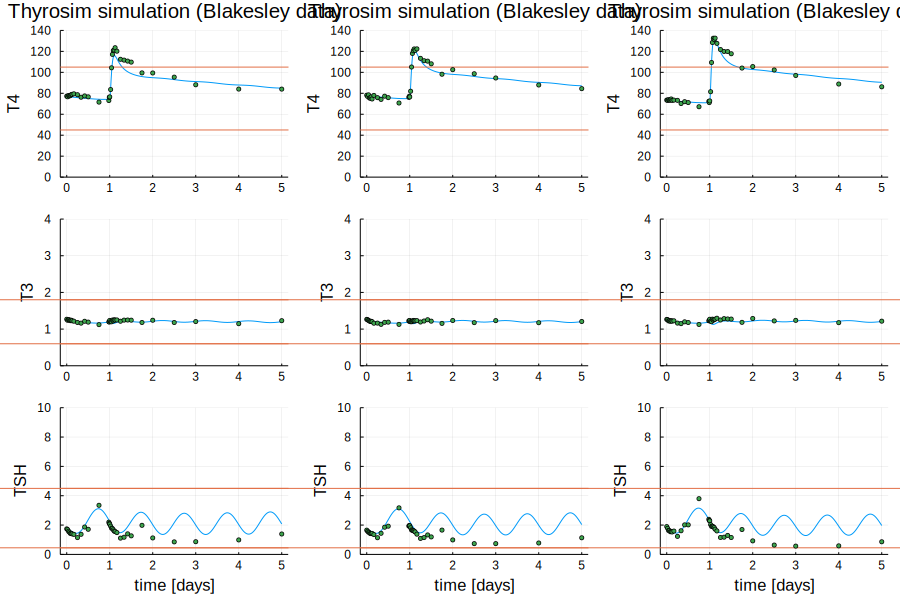

In [60]:
# blakesley 
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
cbk   = ContinuousCallback(blakesley_condition, add_dose!); 
ic, p = initialize([1.0; 0.88; 1.0; 0.88]) 
p[fitting_index] = result.minimizer

#400 T4
T4_init_400, T3_init_400, TSH_init_400 = my400_data[1, :]
set_patient_ic!(ic, p, T4_init_400, T3_init_400, TSH_init_400, steady_state=true, set_tsh_lag=true)
p[55] = 400 / 777.0
p[56] = 0.0
prob400 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol400 = solve(prob400)
a = plot_blakesley(sol400, "400")

# 450 T4
T4_init_450, T3_init_450, TSH_init_450 = my450_data[1, :]
set_patient_ic!(ic, p, T4_init_450, T3_init_450, TSH_init_450, steady_state=true, set_tsh_lag=true)
p[55] = 450 / 777.0
prob450 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol450 = solve(prob450)
b = plot_blakesley(sol450, "450")

#600 T4
T4_init_600, T3_init_600, TSH_init_600 = my600_data[1, :]
set_patient_ic!(ic, p, T4_init_600, T3_init_600, TSH_init_600, steady_state=true, set_tsh_lag=true)
p[55] = 600 / 777.0
prob600 = ODEProblem(thyrosim,ic,(0.0, 120.0),p,callback=cbk)
sol600 = solve(prob600)
c = plot_blakesley(sol600, "600")

plot(a, b, c, layout=(1, 3), size=(900, 600))

In [25]:
# jonklaas
graphs = Vector{Any}(undef, 15)
for i in 1:15
    height, weight, sex = patient_param[i, :]
    T4init, T3init, TSHinit = patient_t4[i, 1], patient_t3[i, 1], patient_tsh[i, 1]
    T3dose = patient_dose[i]
    ic, p = initialize([0.0; 0.88; 0.0; 0.88], true, height, weight, Bool(sex)) 
    set_patient_ic!(ic, p, T4init, T3init, TSHinit, steady_state=true, set_tsh_lag=true)
    p[55] = 0.0
    p[56] = T3dose / 651.0
    cbk   = ContinuousCallback(jonklaas_condition, add_dose!); 
    p[fitting_index] = result.minimizer
    prob = ODEProblem(thyrosim,ic,(0.0, 8.0),p,callback=cbk)
    sol = solve(prob)
    graphs[i] = plot_jonklaas(sol, patient_t4[i, :], patient_t3[i, :], patient_tsh[i, :])
end

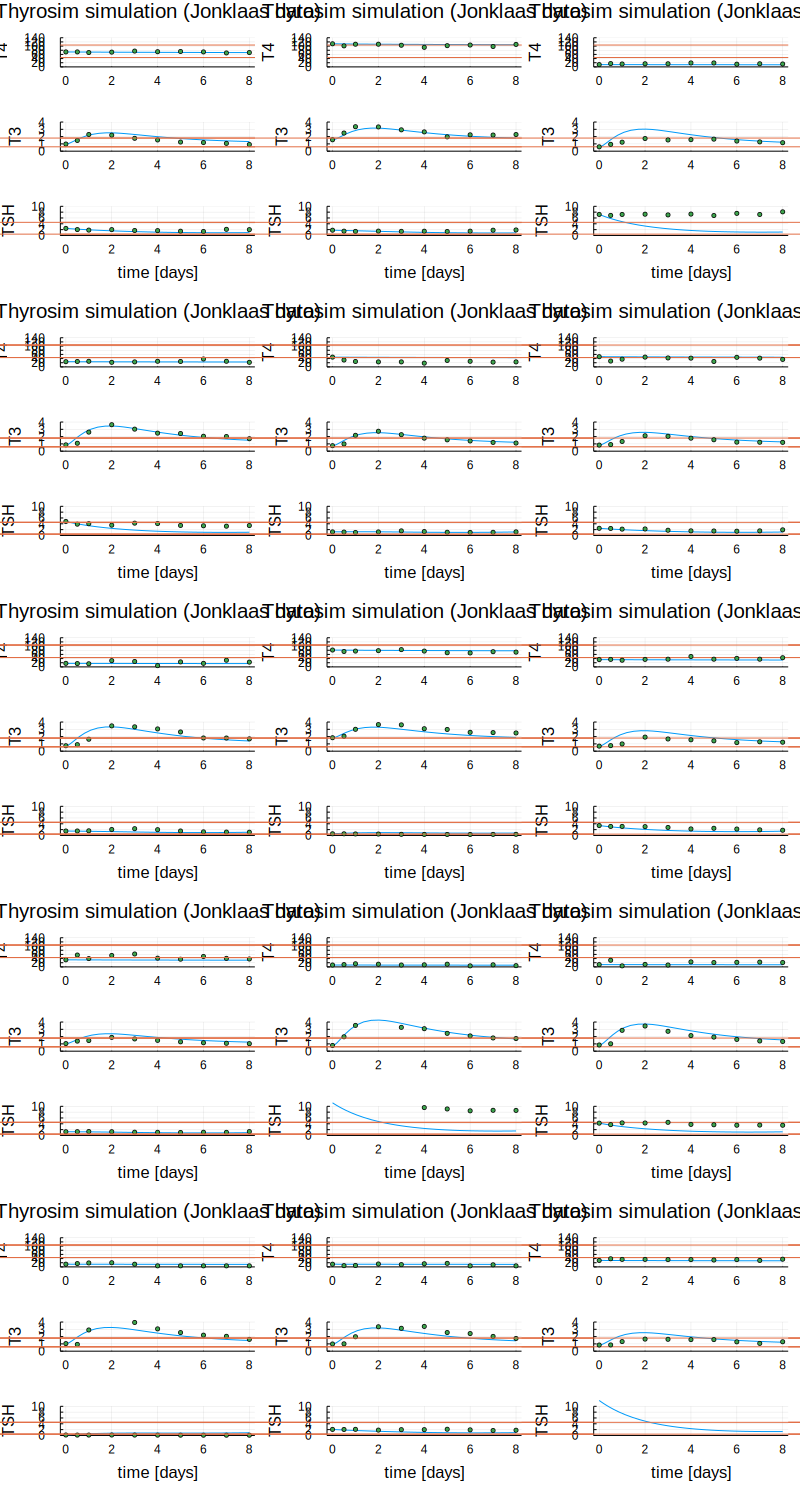

In [68]:
plot(graphs..., layout=(5, 3), size=(800, 1500))
# plot(graphs[1], graphs[2], layout=(1, 2))

# Fitting on full training data

In [15]:
println(result)

 * Status: failure (reached maximum number of iterations) (line search failed)

 * Candidate solution
    Minimizer: [6.30e-01, 1.30e+01, 9.74e+01,  ...]
    Minimum:   5.641801e+01

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [8.89e-01, 1.69e+00, 6.99e+01,  ...]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   645  (vs limit Inf)
    Iterations:    500
    f(x) calls:    909



In [16]:
println(result.minimizer)

[0.6301355778551535, 12.992043552093111, 97.37022598128038, 50.45441712834436, 4.805305475659011, 3.6312259335780745, 4.409486963249612, 6.9400426837655775, 2.2829695284777327, 9.456228561804139]
